This code in thenotebook calculates the CLV for a customer that uses auto-pay and for a customer that does not use auto-pay.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
churn = pd.DataFrame(
    {
        "autopay": [0.032, 0.070, 0.097, 0.103, 0.095, 0.078, 0.069, 0.059, 0.053],
        "no_autopay": [0.084, 0.122, 0.162, 0.154, 0.134, 0.120, 0.111, 0.096, 0.086],
    }
)

### Create a new DataFrame `churn8` that has the churn values to use for the rest of the caculations

In [3]:
churn8 = churn.iloc[:-1,:].copy()
churn8.iloc[0] = 0
churn8

,autopay,no_autopay
0,0.000,0.000
1,0.070,0.122
2,0.097,0.162
3,0.103,0.154
4,0.095,0.134
5,0.078,0.120
6,0.069,0.111
7,0.059,0.096


**Assumptions:**
 
1. Pessimistic discounting since customers pay at the end of each month, with or without auto-pay.  
2. Contracts for residential customers are annually, customer can't cancel until end of year.
3. The first year of CLV calculation is year2.
4. RMR is $480 for the first full year of the CLV calculation.
5. Neglect the installation charge and cost because the CLV calculation is based on exiting residential customers.
6. Discount number start from 1 given pessimistic discounting in the CLV calculation.
7. Customer at first year CLV calculation has renewed the plan.

In [4]:
monthly_revenue = 40 #only for first year, same for both groups
annual_growth = 0.03 #general rate increases
annual_discount_rate = 0.1 
monthly_discount_rate = (1+annual_discount_rate)**(1/12)-1 #around 0.8%
cost_service = 0.15*monthly_revenue
marketing_cost = 0.05*monthly_revenue #only second year customer
nr_years = 8

### Calculate CLV for non-autopay customers

In [5]:
# create an array with retention rates 
# convert to monthly churn first
# monthly_noautopay = [1-(1-x)**(1/12) for x in churn8.no_autopay]

n2 = 1
lsn = []
for i in range(8):
    nn = n2*(1-churn8.no_autopay[i])
    n2 = nn 
    lsn.append(nn)  

retention_nap = np.repeat(lsn,12) #shape(96,), same for each year

In [6]:
# calculate clv 
discount_nap = np.array(range(1,97))

revenues_nap = np.repeat([40*(1+0.03)**x for x in range(8)],12)
service_nap = 0.15*revenues_nap
marketing_nap = 0.05*revenues_nap
profit_nap = revenues_nap - service_nap - marketing_nap
expected_profit_nap = profit_nap*retention_nap
pv_expected_profit_nap = expected_profit_nap/(1+monthly_discount_rate)**discount_nap # present value of expected profits

clv_nap_list = [pv_expected_profit_nap[0]]
for i in range(1,96):
    money = pv_expected_profit_nap[i] + clv_nap_list[i-1]
    clv_nap_list.append(money)
    
clv_nap = np.array(clv_nap_list)

### Calculate CLV for autopay customers

In [7]:
# create an array with retention rates 
# convert to monthly churn first
a2 = 1
lsa = []
for i in range(8):
    aa = a2*(1-churn8.autopay[i])
    a2 = aa
    lsa.append(aa)
    
retention_ap = np.repeat(lsa,12) #shape(96,), same for each year

In [8]:
# calculate clv 
discount_ap = np.array(range(1,97))

revenues_ap = np.repeat([40*(1+0.03)**x for x in range(8)],12)
service_ap = 0.15*revenues_ap
marketing_ap = 0.05*revenues_ap
profit_ap = revenues_ap - service_ap - marketing_ap
expected_profit_ap = profit_ap*retention_ap
pv_expected_profit_ap = expected_profit_ap/(1+monthly_discount_rate)**discount_ap # present value of expected profits

clv_ap_list = [pv_expected_profit_ap[0]]
for i in range(1,96):
    money = pv_expected_profit_ap[i] + clv_ap_list[i-1]
    clv_ap_list.append(money)
    
clv_ap = np.array(clv_ap_list)

In [9]:
time = np.array(range(1,97))
homealarm = pd.DataFrame(
    {"Time": time, "autopay": clv_ap, "no_autopay": clv_nap,"r_autopay": retention_ap, "r_no_autopay": retention_nap}
)
homealarm

,Time,autopay,no_autopay,r_autopay,r_no_autopay
0,1,31.746846,31.746846,1.000000,1.000000
1,2,63.242541,63.242541,1.000000,1.000000
2,3,94.489072,94.489072,1.000000,1.000000
3,4,125.488410,125.488410,1.000000,1.000000
4,5,156.242510,156.242510,1.000000,1.000000
...,...,...,...,...,...
91,92,1762.733926,1525.389453,0.550658,0.381223
92,93,1773.087712,1532.557435,0.550658,0.381223
93,94,1783.359589,1539.668710,0.550658,0.381223
94,95,1793.550204,1546.723728,0.550658,0.381223


### Create a line graph of CLV for both autopay and non-autopay customers 

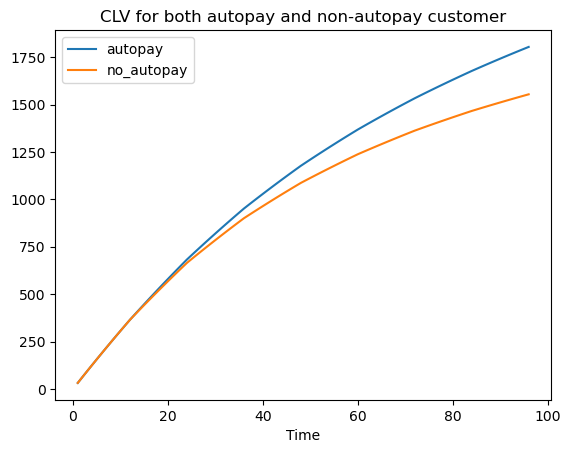

In [10]:
homealarm.plot(x="Time", y=["autopay", "no_autopay"])
plt.title("CLV for both autopay and non-autopay customer")
plt.show()

### Create a line graph of the retention rate for both autopay and non-autopay customer 

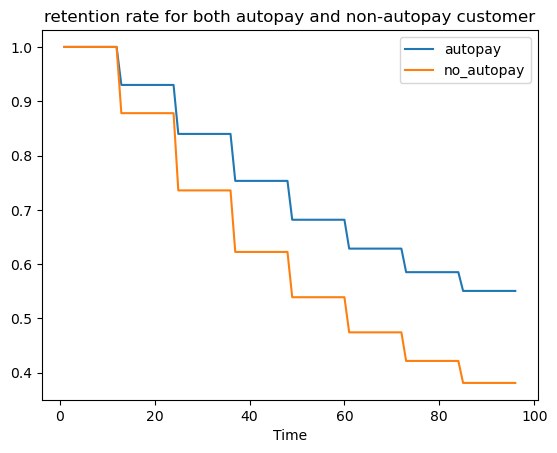

In [11]:
retention = pd.DataFrame(
    {"Time": time, "autopay": retention_ap, "no_autopay": retention_nap}
)
retention.plot(x="Time", y=["autopay", "no_autopay"])
plt.title("retention rate for both autopay and non-autopay customer")
plt.show()

### Calculate the maximum amount to spend on autopay incentives

In [12]:
max_pay = clv_ap[95] - clv_nap[95] # insert your code here
print(f"Maxium amount to spend on autopay incentives is {max_pay.round(2)}")

Maxium amount to spend on autopay incentives is 249.94


### Suggested marketing actions

1. Give one-time reward or discounted monthly price for existing customers at the year they start autopay. The incentive amount I recommend using is \$20.
2. Provide additional service in autopay system for the existing customers who switch to autopay. For example, a VIP program where existing customer can accumulate their consumption points and keep a record of order history. 